<a href="https://colab.research.google.com/github/nsedov/DLS1/blob/main/Autoencoder/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [ ]:
import numpy as np
from torch.autograd import Variable
from torch import nn
from torchvision import datasets
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import os
from skimage.transform import resize
from tqdm.notebook import tqdm
import skimage.io
import pandas as pd
from time import time
from IPython.display import clear_output
import copy
%matplotlib inline

In [ ]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [ ]:
train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    train_size=0.9, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_photos, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_photos, batch_size=32)

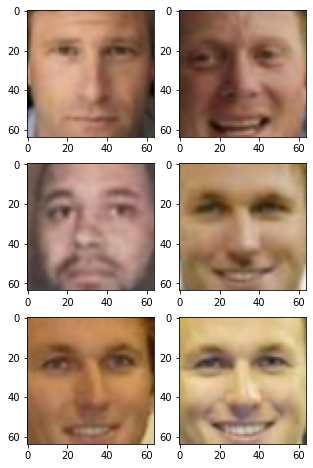

In [ ]:
examples = next(iter(train_loader))
plt.figure(figsize=(5, 8))
for i, img  in enumerate(examples[:6]):
    plt.subplot(3, 2, i + 1)
    plt.imshow(img)
plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [ ]:
dim_code = 64 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
from copy import deepcopy

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features= 64 * 64 * 3, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=dim_code)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=dim_code),
            nn.ReLU(),
            nn.Linear(in_features=dim_code, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features= 64 * 64 * 3)
        )

    def sample(self, z):
        generated = self.decoder(z)
        generated = torch.sigmoid(generated)
        generated = generated.view(-1, 64, 64, 3)
        return generated

    def forward(self, x):
        #print(x.shape)
        x = torch.flatten(x, start_dim = 1).float()
        #print(x.shape)
        latent_code = self.encoder(x)
        #print(latent_code.shape)
        reconstruction = torch.sigmoid(self.decoder(latent_code))#.view(-1, 64, 64, 3)
        #print(reconstruction.shape)
        
        return reconstruction, latent_code

In [ ]:
#check if works
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
from torchsummary import summary
autoencoder = Autoencoder().to(device)
summary(autoencoder.cuda(), (64, 64, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       6,291,968
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 64]          32,832
            Linear-4                   [-1, 64]           4,160
              ReLU-5                   [-1, 64]               0
            Linear-6                  [-1, 512]          33,280
              ReLU-7                  [-1, 512]               0
            Linear-8                [-1, 12288]       6,303,744
Total params: 12,665,984
Trainable params: 12,665,984
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.11
Params size (MB): 48.32
Estimated Total Size (MB): 48.47
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss(reduction='sum')
autoencoder = Autoencoder().cuda()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
#test
# b = next(iter(train_loader))
# b.shape
# with torch.no_grad():
#     bm, _ = autoencoder(b.to(device))
#     print(bm)
#     ls = criterion(bm.view(-1, 64, 64, 3).float(), b.to(device).float())
#     print(ls)

In [ ]:
n_epochs = 10
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    ep_loss = 0
    train_losses_per_epoch = []
    for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        reconstruction, latent = autoencoder(batch)
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        loss = criterion(reconstruction.float(), batch.to(device).float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_loss = 0
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch in val_loader:
          reconstruction, latent = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 64, 64, 3)
          loss = criterion(reconstruction.float(), batch.to(device).float())
          val_losses_per_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/10 [00:00<?, ?it/s]

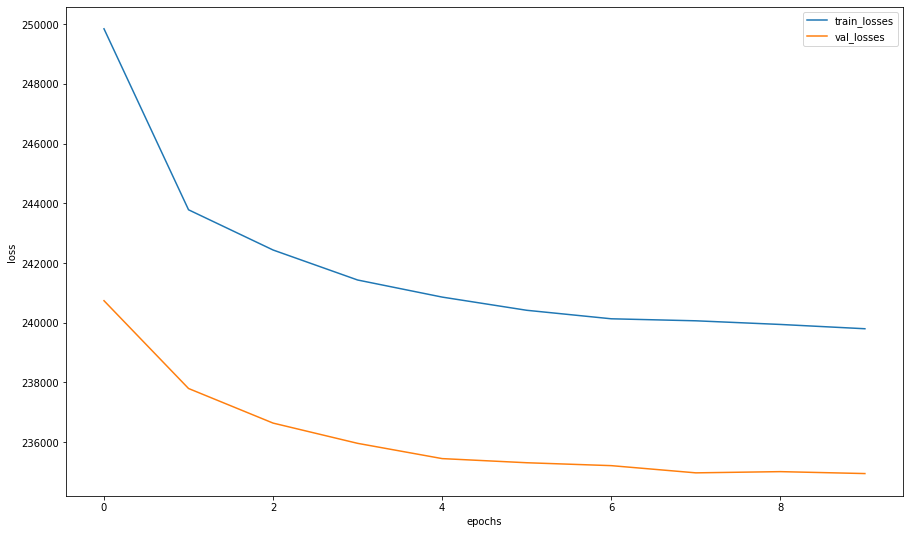

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_losses")
plt.plot(val_losses, label="val_losses")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [ ]:
  autoencoder.eval()
  with torch.no_grad():
      for batch in val_loader:
        reconstruction, _ = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 64, 64, 3)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

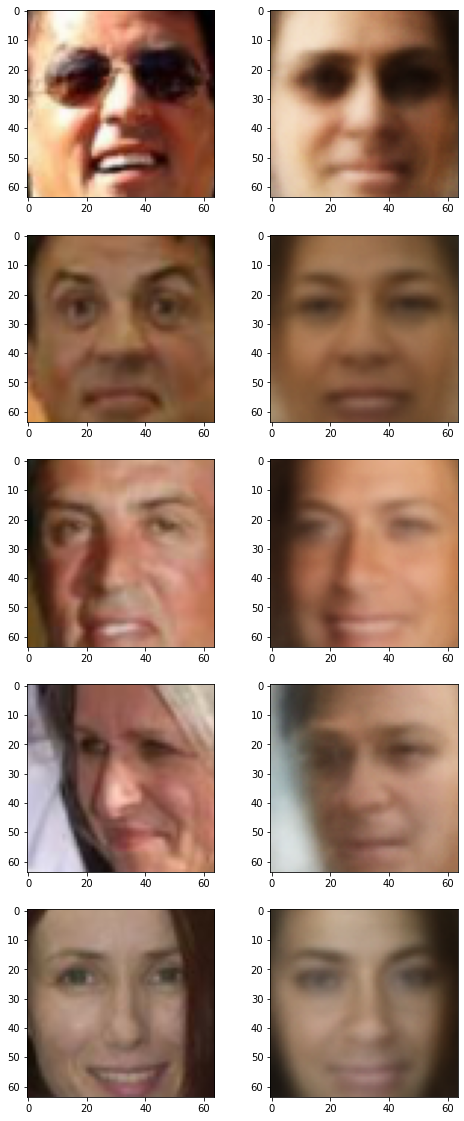

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt)
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res)

Not bad, right? 

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

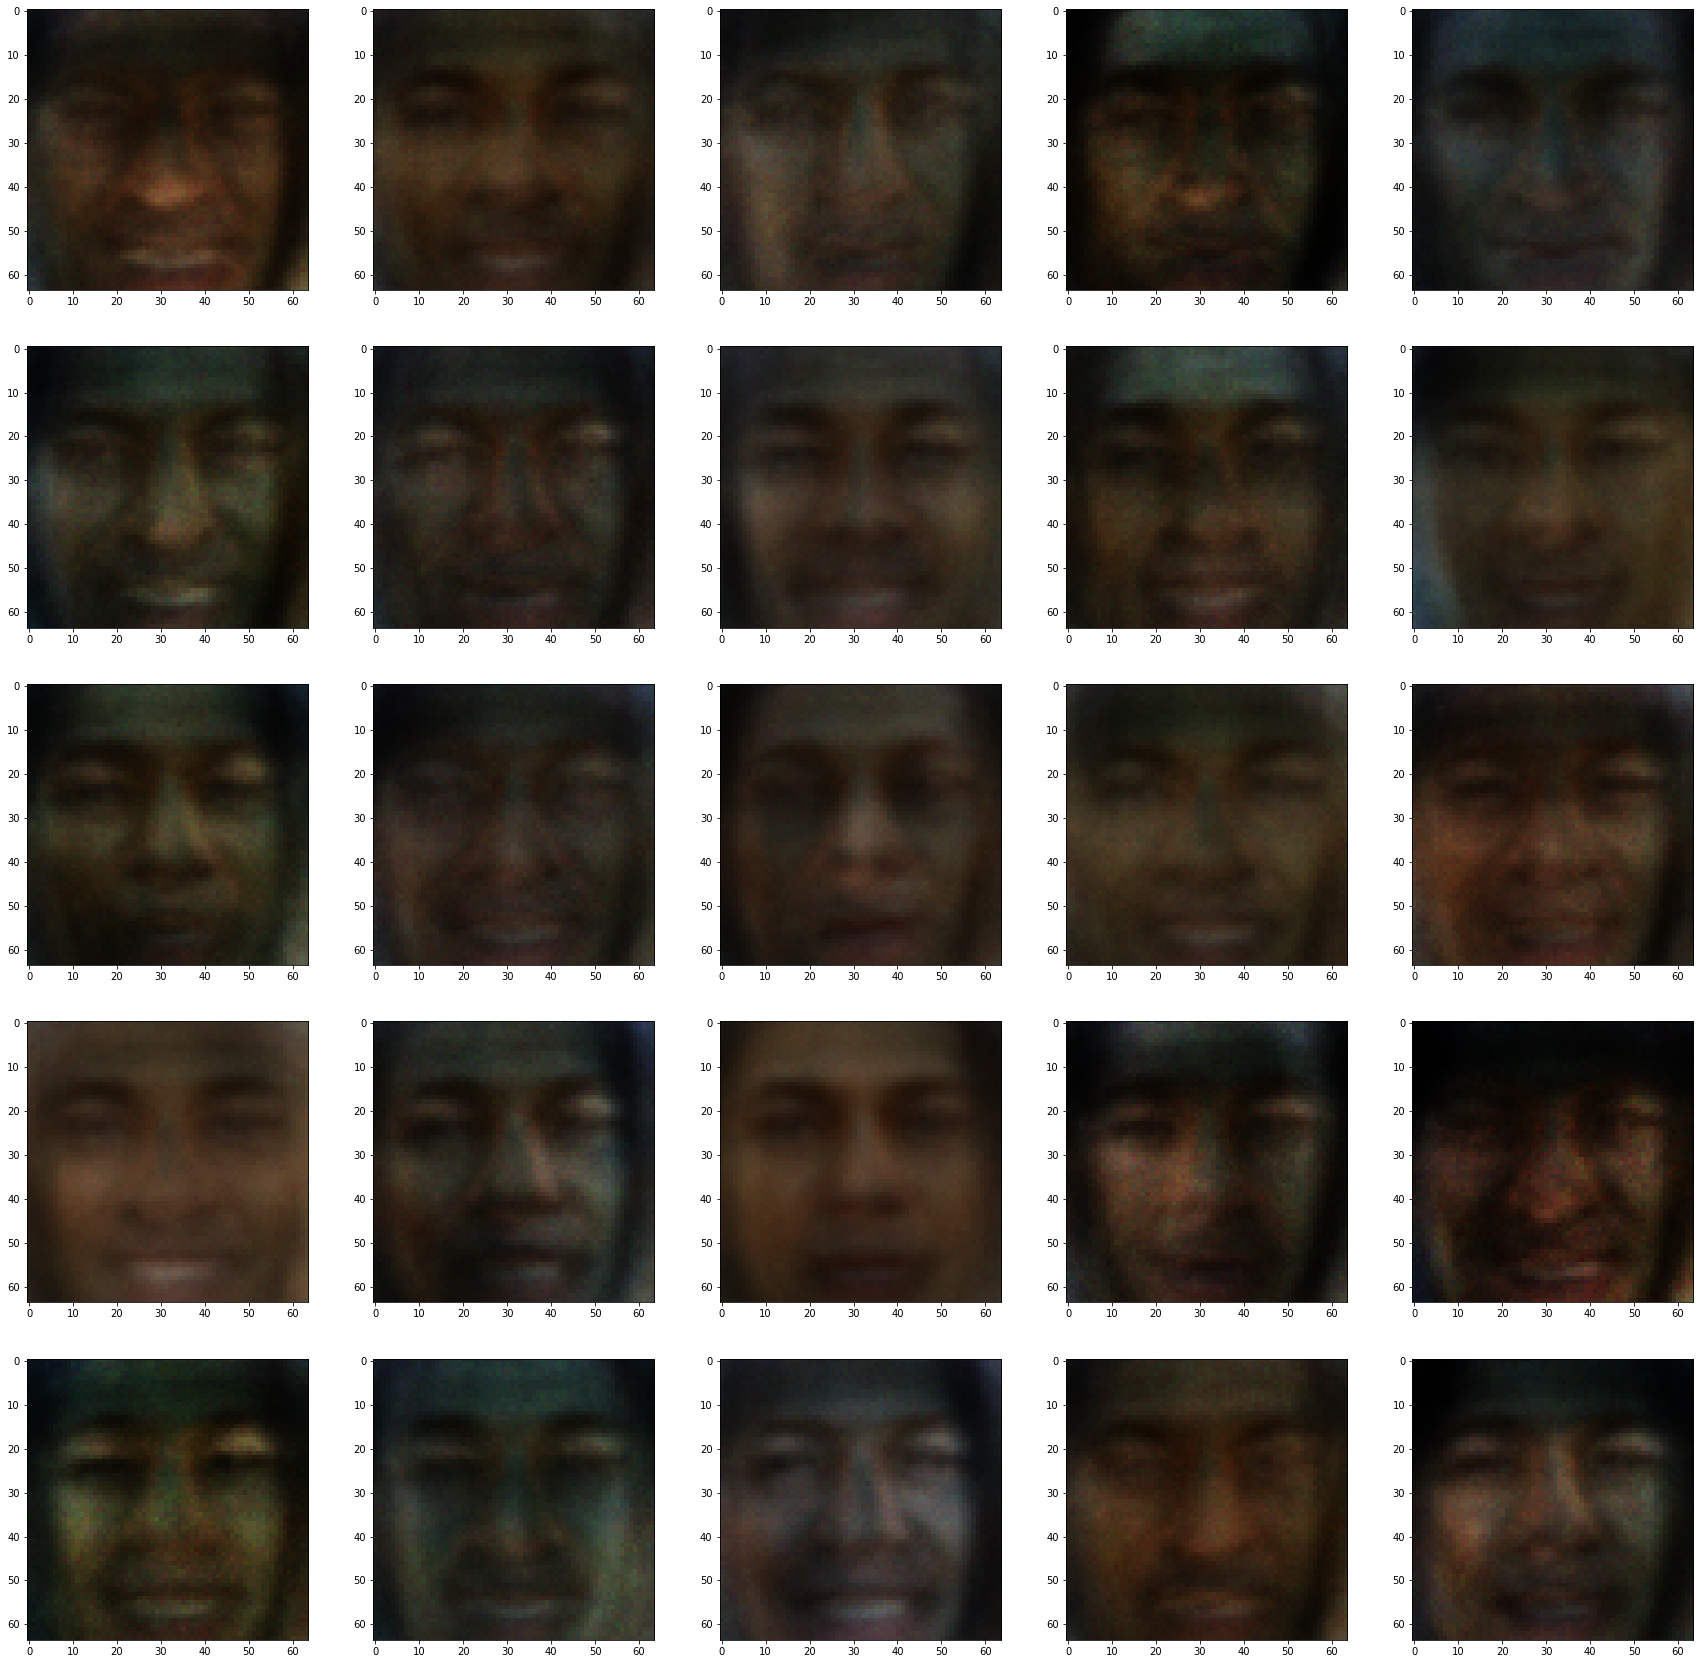

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code)
autoencoder.eval()
with torch.no_grad():
    output = autoencoder.sample(torch.FloatTensor(z).to(device))

plt.figure(figsize=(30, 30))
for i, fig in enumerate(output):
  plt.subplot(5, 5, i+1)
  plt.imshow(fig.cpu().detach().numpy())

## Time to make fun! (4 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
train_attrs.columns

Index(['Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth',
       'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair',
       'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling',
       'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash',
       'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair',
       'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead',
       'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows',
       'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose',
       'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open',
       'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee',
       'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face',
       'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man',
       'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes',
       'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pa

In [ ]:
smile_sorted = np.array(train_attrs.sort_values(by = ['Smiling'], ascending = False)['Smiling'].index)

In [ ]:
smile_sorted

array([ 8643,  1816,  5624, ...,  7506,  1234, 11571])

In [ ]:
persons_num = 25
smiling_faces = train_photos[smile_sorted[:persons_num]]
sad_faces = train_photos[smile_sorted[-persons_num:]]

In [ ]:
autoencoder.eval()
with torch.no_grad():
    smile_data = autoencoder(torch.FloatTensor(smiling_faces).to(device))
    sad_data = autoencoder(torch.FloatTensor(sad_faces).to(device))
smiling_latent = smile_data[1].cpu().detach().numpy()
sad_latent = sad_data[1].cpu().detach().numpy()

In [ ]:
smile_avg = smiling_latent.mean(axis = 0)
sad_avg = sad_latent.mean(axis = 0)
smile_modifier = smile_avg - sad_avg

In [ ]:
example = np.random.randint(low = 0, high = len(train_photos), size = 5)
rand_batch = train_photos[example]

autoencoder.eval()
with torch.no_grad():
    res, latent = autoencoder(torch.FloatTensor(rand_batch).to(device))
    latent = latent.cpu() + smile_modifier
    res = autoencoder.sample(latent.to(device))
    smiling_persons=(res.view(-1, 64, 64, 3).cpu().detach().numpy())

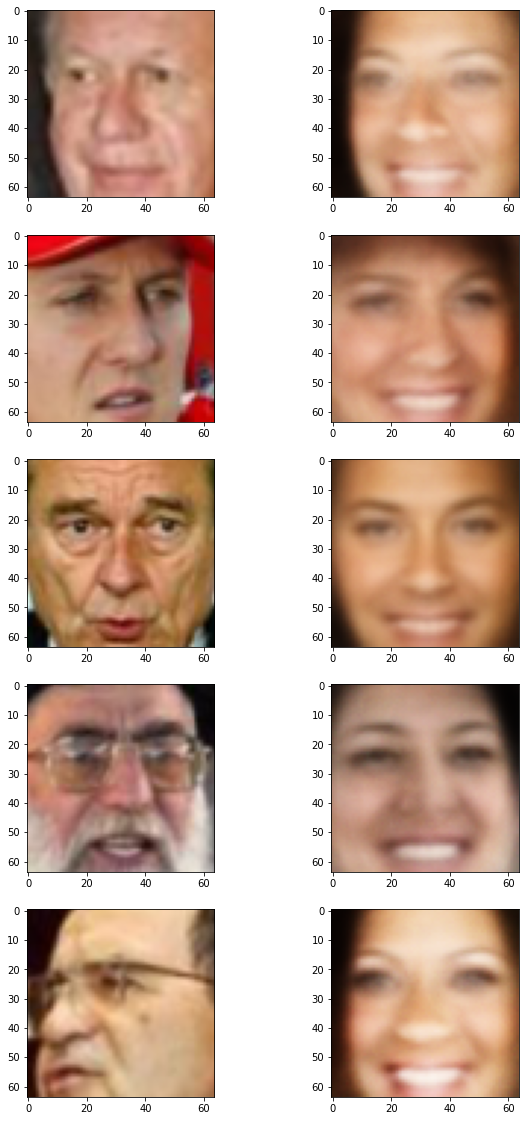

In [ ]:
plt.figure(figsize=(10, 20))
for i, (orig, smile) in enumerate(zip(rand_batch, smiling_persons)):
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(orig)
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(smile)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов) 

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
from torchvision import transforms

In [ ]:
batch_size = 32
# MNIST Dataset

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
dim_code = 32

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features= 28 * 28, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features = dim_code*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=dim_code),
            nn.ReLU(),
            nn.Linear(in_features=dim_code, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features= 28 * 28)
        )

    def encode(self, x):
        #print(x.shape)
        x = torch.flatten(x, start_dim = 1).float()
        #print(x.shape)
        x = self.encoder(x)
        #print(x.shape)
        x = x.view(-1, 2, dim_code)
        #print(x.shape)
        mu = x[:, 0,  :]
        #print(mu.shape)
        log_var = x[:, 1, :]
        #print(log_var.shape)
        return mu, log_var
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.rand_like(std)
            sample = mu + (eps * std)
            return sample
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        #print(x.shape)
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = torch.sigmoid(self.decode(sample))
        return mu, logsigma, reconstruction


Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likehood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction = 'sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likehood(x, reconstruction)

И обучим модель:

In [ ]:
criterion = loss_vae
autoencoder = VAE().cuda()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

In [ ]:
n_epochs = 20
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    ep_loss = 0
    train_losses_per_epoch = []
    for batch, _ in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)
        #print(batch.shape)
        mu, logsigma, reconstruction = autoencoder(batch)
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction.float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_loss = 0
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, _ in test_loader:
          mu, logsigma, reconstruction = autoencoder(batch.to(device))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction.float())
          val_losses_per_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/20 [00:00<?, ?it/s]

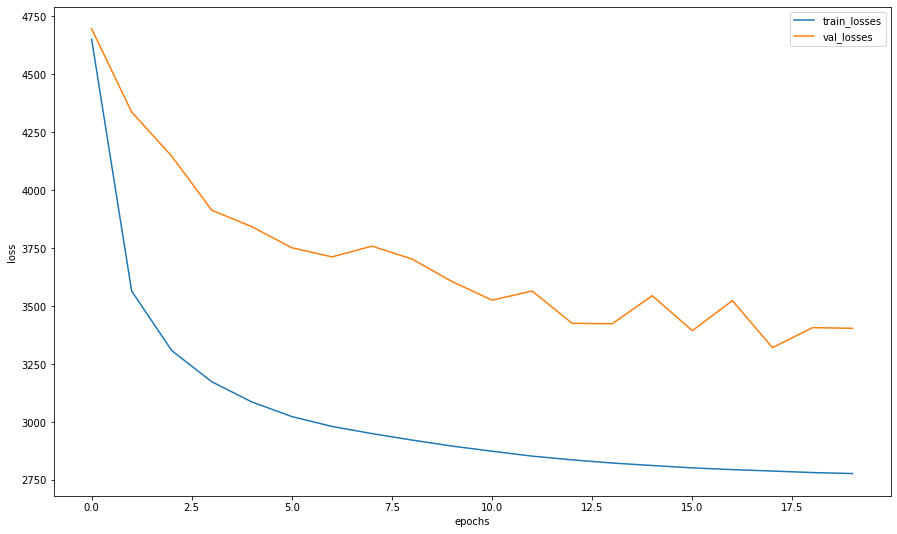

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_losses")
plt.plot(val_losses, label="val_losses")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch, _ in test_loader:
        mu, logsigma, reconstruction = autoencoder(batch.to(device))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.numpy()
        break

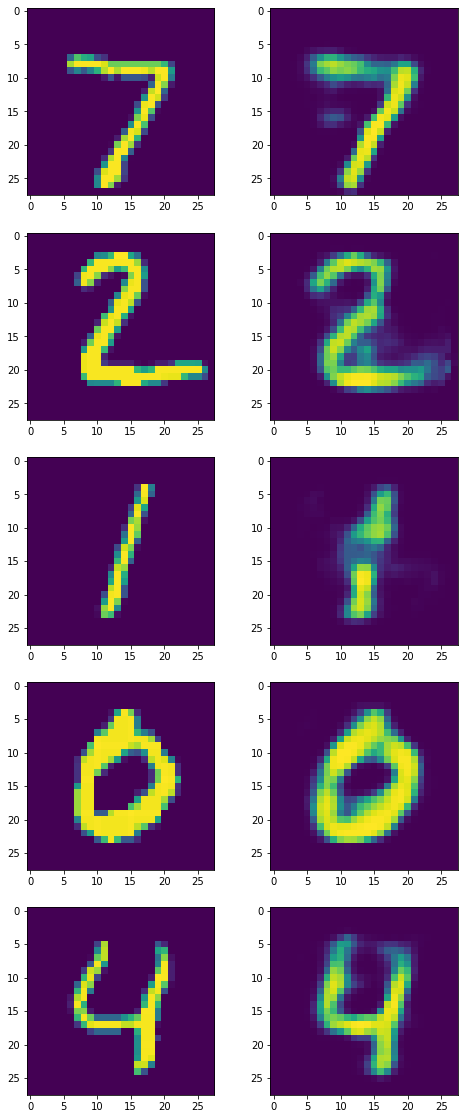

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt[0])
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res[0])

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

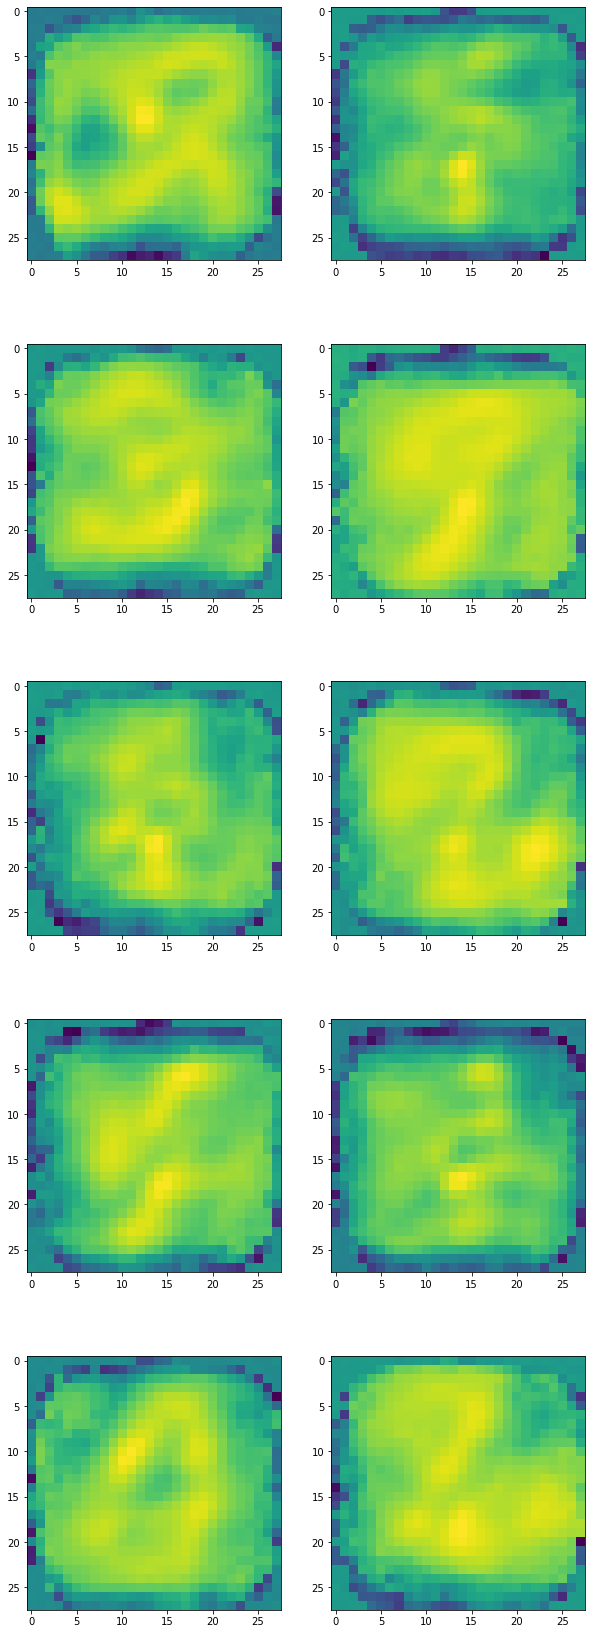

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, dim_code) for i in range(10)])

autoencoder.eval()
with torch.no_grad():
    output =  autoencoder.decode(torch.FloatTensor(z).to(device))
output = output.view(-1, 1, 28, 28)
output = output.cpu().detach().numpy()
plt.figure(figsize=(10, 30))
for i, fig in enumerate(output):
    plt.subplot(5, 2, i+1)
    plt.imshow(fig[0])

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве. 

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
mu_list = []
logsigma_list = []
digits = []
autoencoder.eval()
with torch.no_grad():
    for batch, target in test_loader:
        mu, logsigma, reconstruction = autoencoder(batch.to(device))
        mu = mu.cpu().detach().numpy()
        logsigma = logsigma.cpu().detach().numpy()
        mu_list.extend(list(mu))
        logsigma_list.extend(list(logsigma))
        digits.extend(list(target.cpu().numpy()))

In [ ]:
from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(mu_list)

In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': digits})

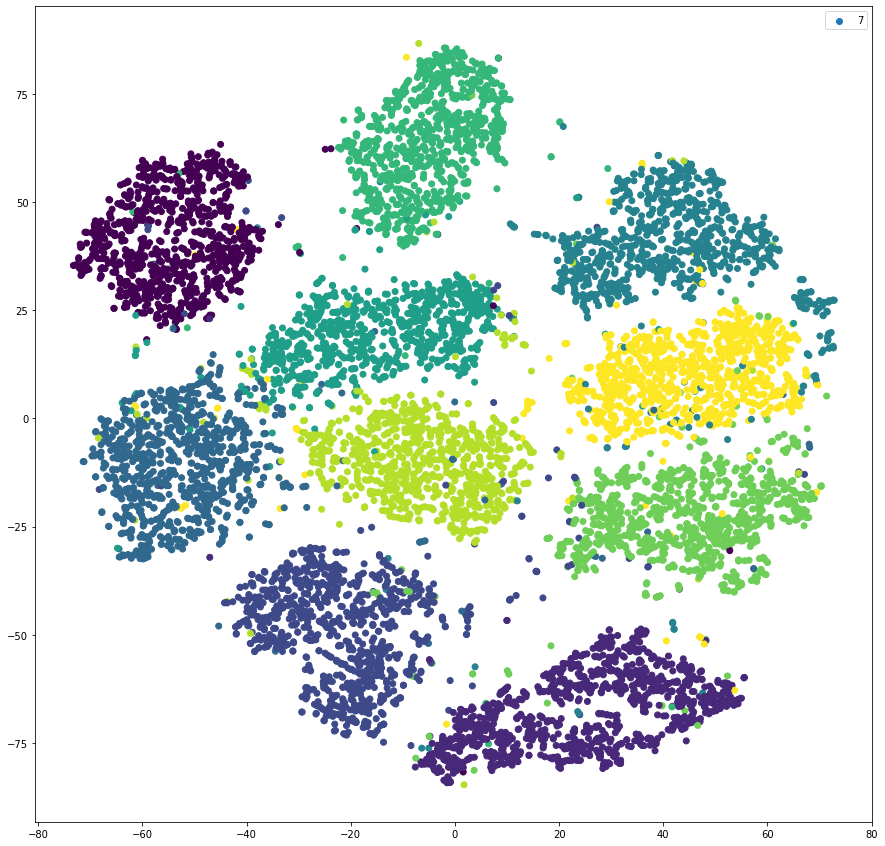

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = digits)
plt.legend(digits)
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
import copy

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features= 28 * 28, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features = dim_code*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code + 10, out_features=dim_code + 10),
            nn.ReLU(),
            nn.Linear(in_features=dim_code + 10, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features= 28 * 28)
        )

    def encode(self, x):
        class_num = x[0]
        x = torch.flatten(x[1], start_dim = 1).float()
        x = self.encoder(x)
        x = x.view(-1, 2, dim_code)
        mu = x[:, 0,  :]
        logsigma = x[:, 1, :]
        return mu, logsigma, class_num
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.rand_like(std)
            sample = mu + (eps * std)
            return sample
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, class_num):
        z = torch.cat((class_num, z), dim = 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma, class_num = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = torch.sigmoid(self.decode(sample, class_num))
        return mu, logsigma, reconstruction

In [ ]:
criterion = loss_vae
autoencoder = CVAE().cuda()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=5e-4)

In [ ]:
n_epochs = 20
train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    autoencoder.train()
    ep_loss = 0
    train_losses_per_epoch = []
    for batch, digit in train_loader:
        optimizer.zero_grad()

        batch = batch.to(device)

        one_hot = np.zeros((len(digit), 10))
        one_hot[np.arange(len(digit)), digit] = 1
        one_hot = torch.FloatTensor(one_hot).to(device)

        #print(batch.shape)
        mu, logsigma, reconstruction = autoencoder((one_hot, batch))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction.float())
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())

    train_losses.append(np.mean(train_losses_per_epoch))

    autoencoder.eval()
    val_loss = 0
    val_losses_per_epoch = []
    with torch.no_grad():
        for batch, digit in test_loader:
          batch = batch.to(device)

          one_hot = np.zeros((len(digit), 10))
          one_hot[np.arange(len(digit)), digit] = 1
          one_hot = torch.FloatTensor(one_hot).to(device)
          
          mu, logsigma, reconstruction = autoencoder((one_hot, batch))
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(batch.to(device).float(), mu, logsigma, reconstruction.float())
          val_losses_per_epoch.append(loss.item())
    
    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

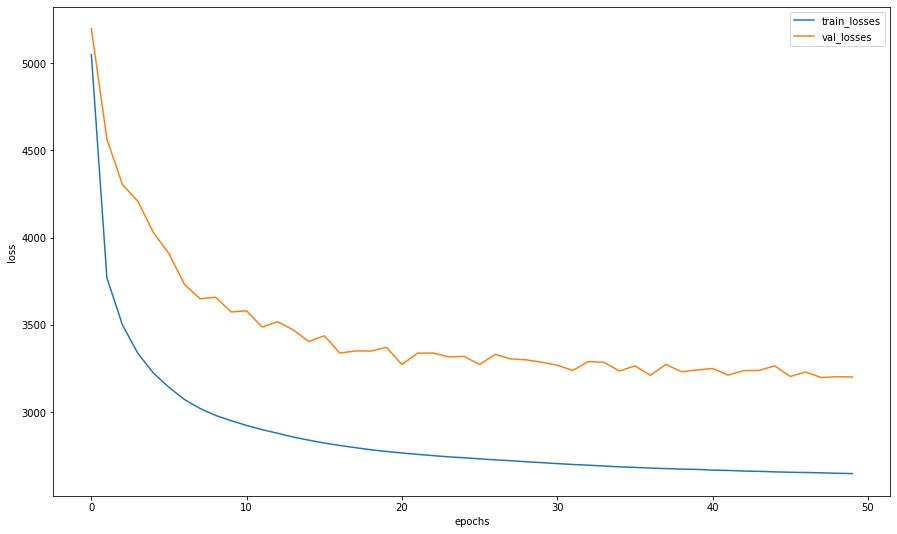

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_losses, label="train_losses")
plt.plot(val_losses, label="val_losses")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
autoencoder.eval()
with torch.no_grad():
    for batch, digit in test_loader:
        batch = batch.to(device)
        one_hot = np.zeros((len(digit), 10))
        one_hot[np.arange(len(digit)), digit] = 1
        one_hot = torch.FloatTensor(one_hot).to(device)
        mu, logsigma, reconstruction = autoencoder((one_hot, batch))
        reconstruction = reconstruction.view(-1, 1, 28, 28)
        result = reconstruction.cpu().detach().numpy()
        ground_truth = batch.cpu().detach().numpy()
        break

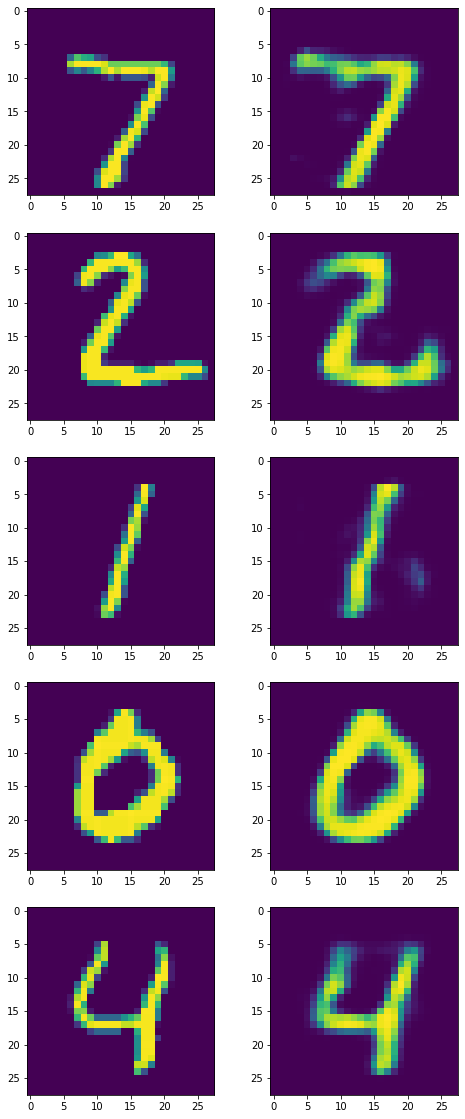

In [ ]:
plt.figure(figsize=(8, 20))
for i, (gt, res) in enumerate(zip(ground_truth[:5], result[:5])):
  plt.subplot(5, 2, 2*i+1)
  plt.imshow(gt[0])
  plt.subplot(5, 2, 2*i+2)
  plt.imshow(res[0])

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

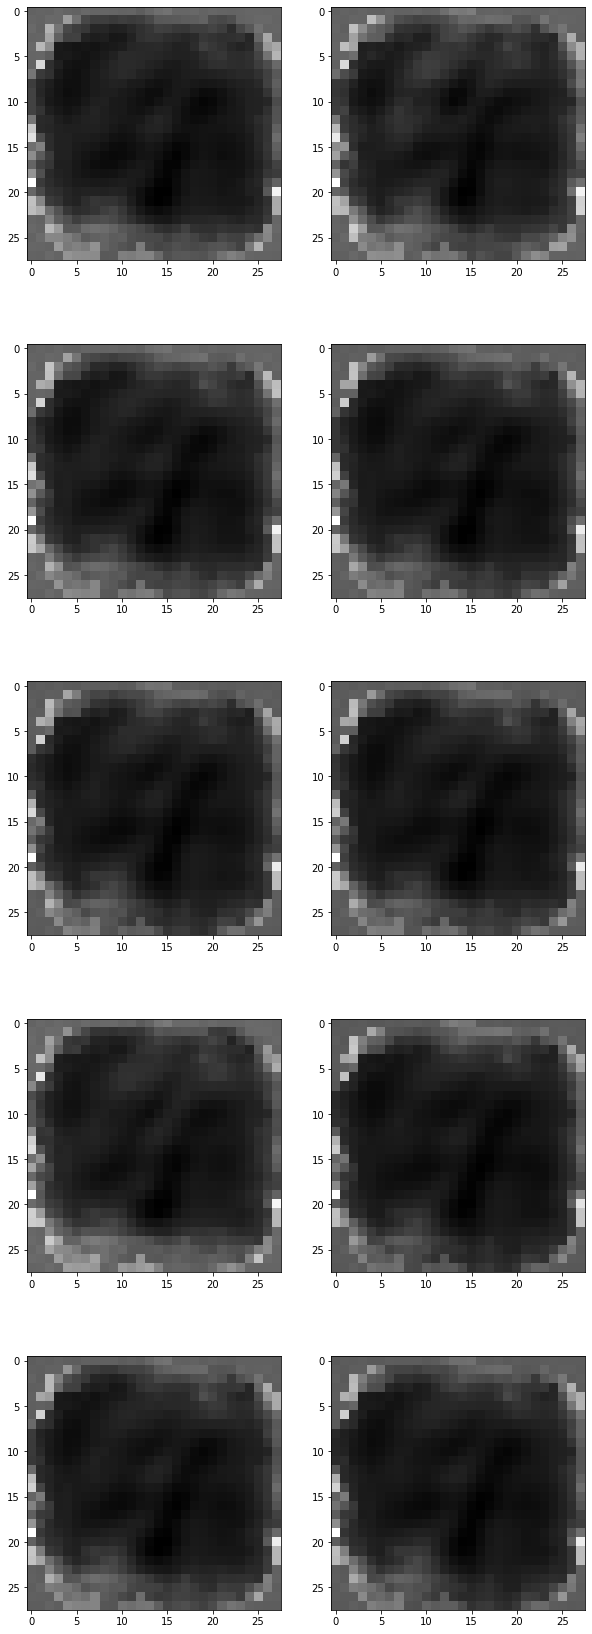

In [ ]:
digit = np.arange(10)
one_hot = np.zeros((len(digit), 10))
one_hot[np.arange(len(digit)), digit] = 1
#ne_hot = torch.FloatTensor(one_hot).to(device)

val = np.random.normal(0, 1, dim_code)
z = np.array([val for i in range(10)])

autoencoder.eval()
with torch.no_grad():
    one_hot = torch.FloatTensor(one_hot).to(device)
    z = torch.FloatTensor(z).to(device)
    output =  autoencoder.decode(z, one_hot)
output = output.view(-1, 1, 28, 28)
output = output.cpu().detach().numpy()
plt.figure(figsize=(10, 30))
for i, fig in enumerate(output):
    plt.subplot(5, 2, i+1)
    plt.imshow(fig[0], cmap='Greys')

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
mu_list = []
logsigma_list = []
digits = []
autoencoder.eval()
with torch.no_grad():
    for batch, digit in test_loader:
        batch = batch.to(device)
          
        one_hot = np.zeros((len(digit), 10))
        one_hot[np.arange(len(digit)), digit] = 1
        one_hot = torch.FloatTensor(one_hot).to(device)

        mu, logsigma, reconstruction = autoencoder((one_hot, batch))
        mu = mu.cpu().detach().numpy()
        logsigma = logsigma.cpu().detach().numpy()
        mu_list.extend(list(mu))
        logsigma_list.extend(list(logsigma))
        digits.extend(list(digit.cpu().numpy()))

In [ ]:
from sklearn.manifold import TSNE
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(mu_list)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': digits})

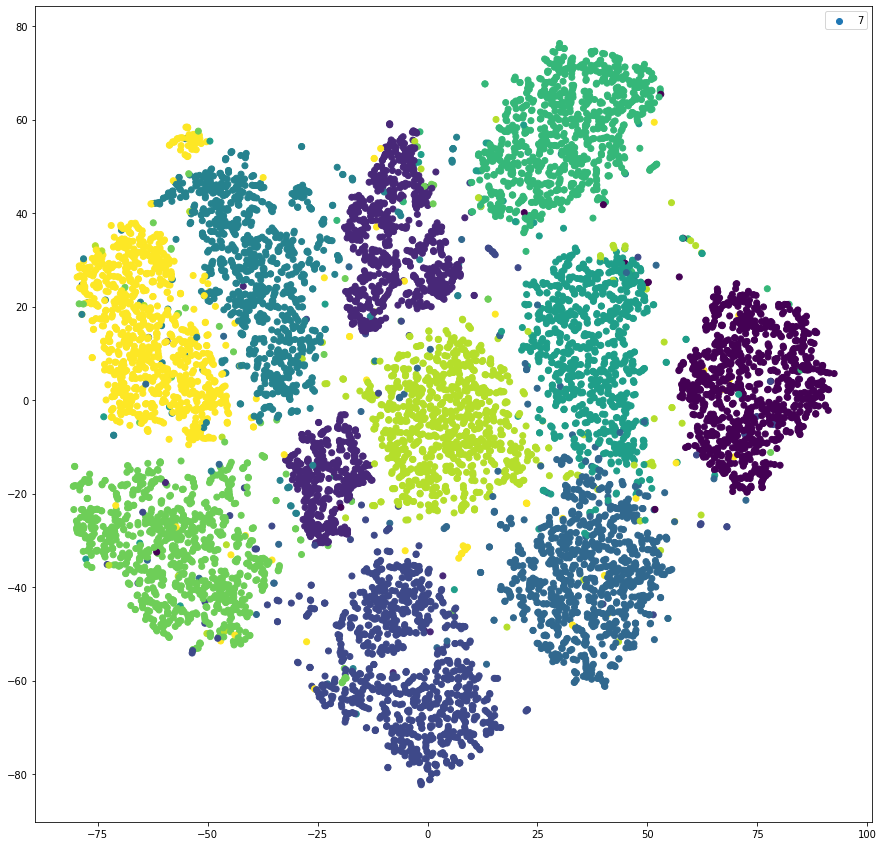

In [ ]:
plt.figure(figsize=(15, 15))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c = digits)
plt.legend(digits)
plt.show()